# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
import random
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Import necessary libraries............................
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#from torchvision.transforms import v2
from torchvision import transforms, models
from torch.optim import lr_scheduler
import torch.nn.functional as F # activation function
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset
from tempfile import TemporaryDirectory
from torchsummary import summary
import time
%matplotlib inline

In [2]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce 940MX
Using device: cuda


In [3]:
data_dir = './rice-dataset/'
print(os.listdir(data_dir)[:4])

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


# Count the image per Class

In [4]:
def image_count(data_dir):
    print(f'\nCounting Images in Category set :')
        
    # Iterate over each category (subfolder) in the split
        
    for sub_path in sorted(os.listdir(data_dir)):
        sub_cat = os.path.join(data_dir,sub_path)
        # Count the number of files, assuming they are all images
        num_images = len([name for name in os.listdir(sub_cat) if os.path.isfile(
                os.path.join(sub_cat, name))])
        print(f"    {sub_path}: {num_images} images")


In [5]:
image_count(data_dir=data_dir)


Counting Images in Category set :
    Bacterialblight: 1584 images
    Blast: 1440 images
    Brownspot: 1600 images
    Tungro: 1308 images


# Data Augmentation

In [19]:
train_transform = transforms.Compose([
    #transforms.Resize((128,128)),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

test_transform = transforms.Compose([
    #transforms.Resize((128,128)),
    transforms.Resize((224,224)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

val_transform = transforms.Compose([
    #transforms.Resize((128,128)),
    transforms.Resize((224,224)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])



In [20]:
dataset = datasets.ImageFolder(
   root= data_dir
)
print(dataset)
print(f'Dataset class is : {dataset.classes}')

Dataset ImageFolder
    Number of datapoints: 5932
    Root location: ./rice-dataset/
Dataset class is : ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


In [21]:
torch.manual_seed(123)
      
train_size  = int(0.7*len(dataset))
val_size = int(0.25*len(dataset))
test_size = (len(dataset) - train_size - val_size)

train_ds, val_ds, test_ds = random_split(dataset, [train_size,val_size, test_size])

# Now manually apply transforms by modifying the `.dataset` attribute
train_ds.dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_ds.dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)
test_ds.dataset = datasets.ImageFolder(root=data_dir, transform=test_transform)

print(f'Train dataset : {len(train_ds)}, {type(train_ds)}')
print(f'Test dataset : {len(test_ds)}')
print(f'Validation dataset : {len(val_ds)}')

Train dataset : 4152, <class 'torch.utils.data.dataset.Subset'>
Test dataset : 297
Validation dataset : 1483


In [22]:
for idx, (fe, la) in enumerate(train_ds):
    print(f'Datapoint :{idx} :\n {fe,la}')
    if idx ==1:
        break

Datapoint :0 :
 (tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 0)
Datapoint :1 :
 (tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -

In [23]:
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [24]:
# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [25]:
batch_size = 64
# DataLoaders for training and validation..........
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [27]:
# Moving data into GPU, WrappedDataLoader
train_dataloader = DeviceDataLoader(train_loader, device)
valid_dataloader = DeviceDataLoader(valid_loader, device)
test_dataloader = DeviceDataLoader(test_loader, device)

# Image Visualize

torch.Size([64, 3, 224, 224])
Augmented Image:


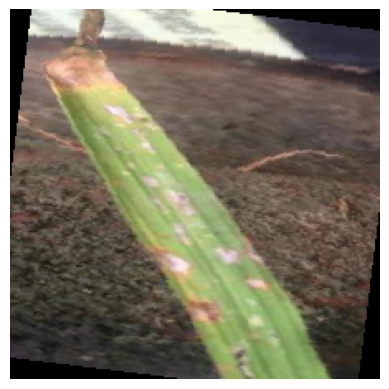

Label: Blast
Original Valid Image:


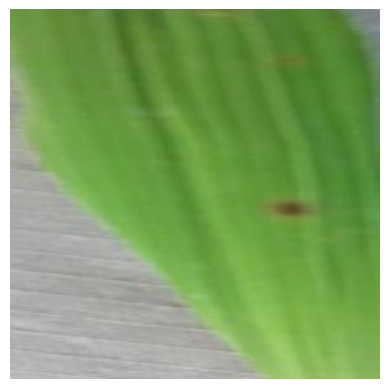

Label: Brownspot
Batch of Augmented Images:


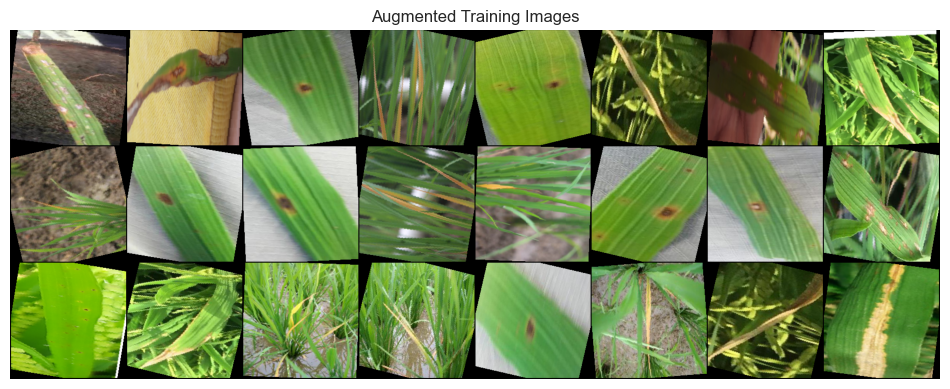

Labels: Blast Blast Brownspot Tungro Brownspot Bacterialblight Blast Bacterialblight Tungro Brownspot Brownspot Tungro Tungro Brownspot Brownspot Blast Brownspot Bacterialblight Tungro Tungro Brownspot Tungro Bacterialblight Bacterialblight
Batch of Original Valid Images:


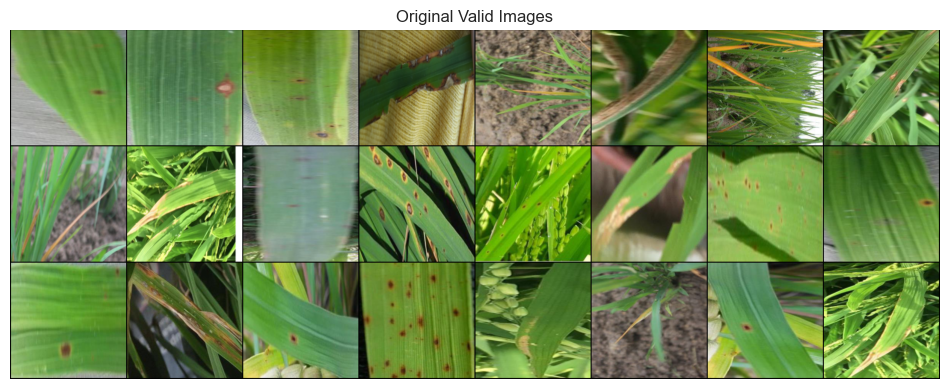

Labels: Brownspot Blast Brownspot Blast Tungro Bacterialblight Tungro Blast Tungro Bacterialblight Brownspot Brownspot Brownspot Blast Brownspot Brownspot Brownspot Blast Brownspot Brownspot Bacterialblight Tungro Brownspot Bacterialblight


In [28]:
# Function to show an image
def imshow(img):
    """Display unnormalized image from a torch Tensor."""
    img = img.clone().detach()  # detach from graph
    img = img / 2 + 0.5         # unnormalize assuming mean=0.5, std=0.5
    npimg = img.numpy()

    # Check if single channel (grayscale) or 3-channel (RGB)
    if npimg.shape[0] == 1:
        npimg = npimg.squeeze()  # remove channel dimension
        plt.imshow(npimg, cmap='gray')
    else:
        npimg = np.transpose(npimg, (1, 2, 0))  # CxHxW → HxWxC
        plt.imshow(npimg)

    plt.axis('off')
    plt.show()


# # # Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

# # Show one augmented image
print('Augmented Image:')
imshow(images[0])
print('Label:', dataset.classes[labels[0]])

# Get some random test images (without augmentation)
valid_dataiter = iter(valid_loader)
valid_images, valid_labels = next(valid_dataiter)

# Show one original test image
print('Original Valid Image:')
imshow(valid_images[0])
print('Label:', dataset.classes[valid_labels[0]])

# 3. Visualizing Augmented Images

# Function to display a batch of images..........................
def imshow_batch(img_batch, labels_batch, title):
    img_batch = img_batch / 2 + 0.5  # Unnormalize
    npimg = torchvision.utils.make_grid(img_batch, nrow=8)
    npimg = npimg.numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze())
    plt.title(title)
    plt.axis('off')
    plt.show()
    # Print labels
    print('Labels:', ' '.join(f'{dataset.classes[labels_batch[j]]}' for j in range(len(labels_batch))))


# Display a batch of augmented images
print('Batch of Augmented Images:')
imshow_batch(images[:24], labels[:24], 'Augmented Training Images')

# # Display a batch of original test images
print('Batch of Original Valid Images:')
imshow_batch(valid_images[:24], valid_labels[:24], 'Original Valid Images')

# Accuracy Function

In [29]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        #images, labels = images.to(DEVICE), labels.to(DEVICE) # move to GPU
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        #images, labels = images.to(DEVICE), labels.to(DEVICE) # move to GPU
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [32]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [33]:
def get_lr(optimizer):
    if optimizer is None:
        raise ValueError("Optimizer is not defined.")
    if not optimizer.param_groups:
        raise ValueError("Optimizer has no param groups.")
    else:
        for param_group in optimizer.param_groups:
            return param_group['lr']

# Customize CNN model
* Used to 4 Convolution layer
* used to 3 hidden layer
* Last hidden layer 512 neurons and final output is 4
* Used to BatchNormalization
* Used to Dropout Regularization

In [36]:
# 4. Defining the Convolutional Neural Network with Dropout
class CNN_model(ImageClassificationBase):
    def __init__(self, in_channels, num_class):
        super(CNN_model, self).__init__()
        # Convolutional layers............................
        self.conv1 = nn.Conv2d(in_channels, out_channels=32, kernel_size=3,padding=1 )  #size remains 128*128
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, 1 )  
        self.bn2 = nn.BatchNorm2d(64)    # BatchNormaliztion
        
        self.conv3 = nn.Conv2d(64, 128, 3, 1 )  
        self.bn3 = nn.BatchNorm2d(128)    # BatchNormaliztion

        self.conv4 = nn.Conv2d(128, 256, 3, 1 )  
        self.bn4 = nn.BatchNorm2d(256)    # BatchNormaliztion
        
        # pooling layer..................................
        self.pool = nn.MaxPool2d(2,2)  
        
        # Dropout layer...............................
        self.dropout_conv = nn.Dropout2d(0.5)  # Dropout Convolution layer
        self.relu = nn.ReLU(inplace=True) # activation function
        
        # Dummy input to calculate the flatten size
        dummy_input = torch.zeros(1, in_channels, 224, 224)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        flatten_size = x.view(1, -1).size(1)

        # fully connected layer.........................
        self.fc_1 = nn.Linear(flatten_size, 1024)
        self.fc_2 = nn.Linear(1024,512)
        self.fc_3 = nn.Linear(512, num_class) # classer = 20

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = x.view(x.size(0),-1) # Flatten layer
        x = self.relu(self.fc_1(x))
        x = self.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x


In [37]:
model_CNN = to_device(CNN_model(3, len(dataset.classes)), device)

summary(model_CNN, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
         Dropout2d-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 110, 110]          18,496
       BatchNorm2d-7         [-1, 64, 110, 110]             128
              ReLU-8         [-1, 64, 110, 110]               0
         MaxPool2d-9           [-1, 64, 55, 55]               0
        Dropout2d-10           [-1, 64, 55, 55]               0
           Conv2d-11          [-1, 128, 53, 53]          73,856
      BatchNorm2d-12          [-1, 128, 53, 53]             256
             ReLU-13          [-1, 128, 53, 53]               0
        MaxPool2d-14          [-1, 128,

# CNN model training

In [38]:
def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):

    history = []  #For collecting the results

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,
                                                epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            #Clip the gradients of an iterable of parameters at specified value.
            #All from pytorch documantation.
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
             # validation

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    torch.save(model.state_dict(), 'CNNmodel.pth')
    return history

In [39]:
%%time
history = [evaluate(model_CNN, valid_dataloader)]
history

CPU times: total: 15.5 s
Wall time: 36.5 s


[{'val_loss': 1.388523817062378, 'val_acc': 0.19844932854175568}]

In [ ]:
num_epoch = 10
lr_rate = 0.001
grad_clip = 0.15
weight_decay = 1e-4
optims = torch.optim.Adam

history += fit_OneCycle(num_epoch, lr_rate, model_CNN, train_dataloader, valid_dataloader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=optims)

  0%|          | 0/65 [00:00<?, ?it/s]

In [128]:
val_acc = []
val_loss = []
train_loss = []

for i in history:
    val_acc.append(i['val_acc'])
    val_loss.append(i['val_loss'])
    train_loss.append(i.get('train_loss'))

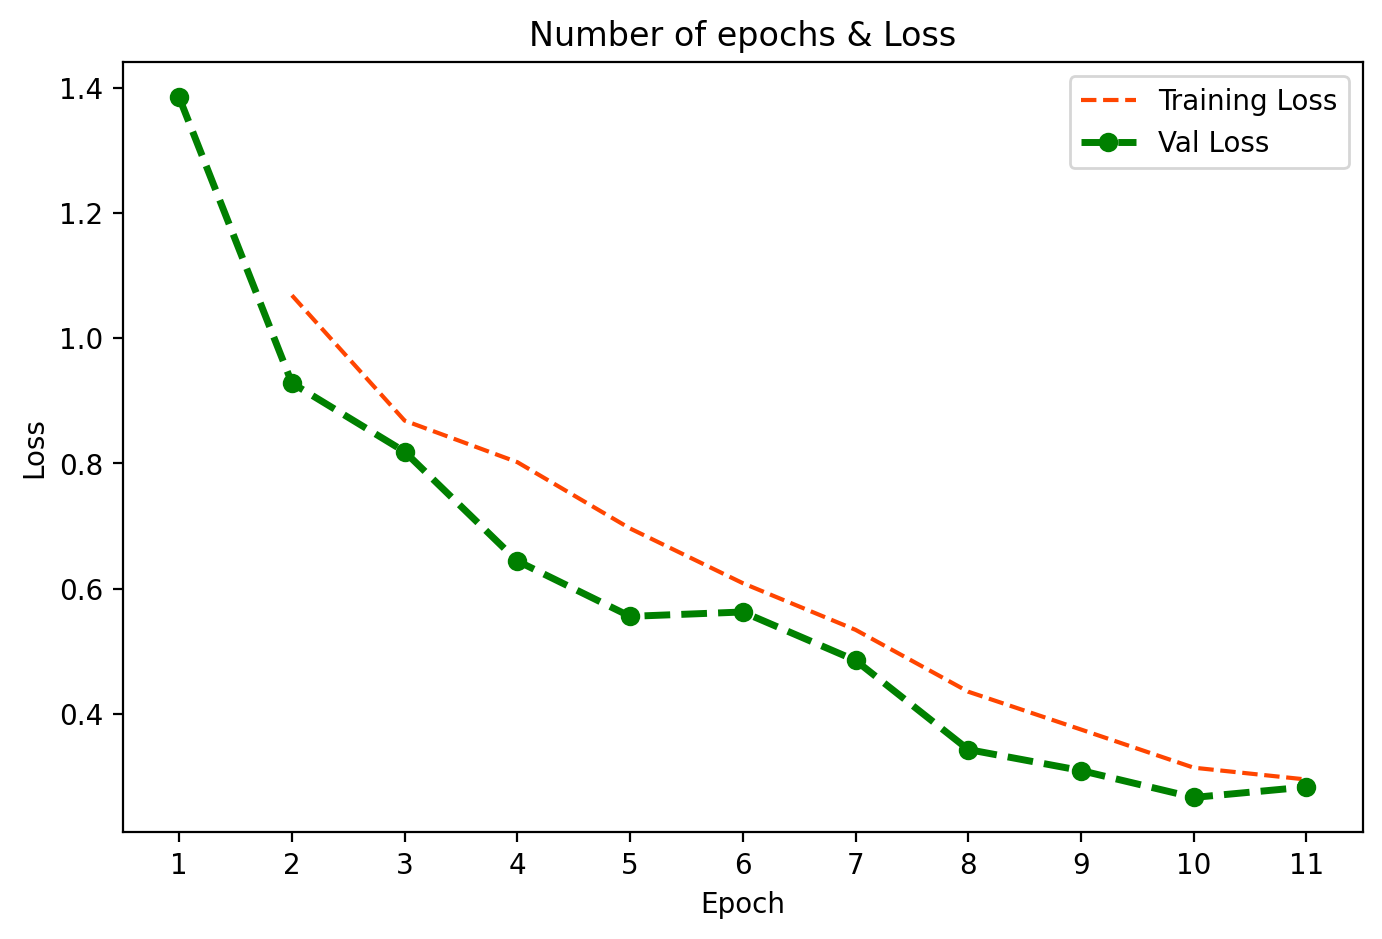

In [129]:
epoch_count = range(1,12)
plt.figure(figsize=(8,5), dpi=200)
plt.plot(epoch_count, train_loss, 'r--', color= 'orangered')
plt.plot(epoch_count, val_loss, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,12,1))
plt.show();

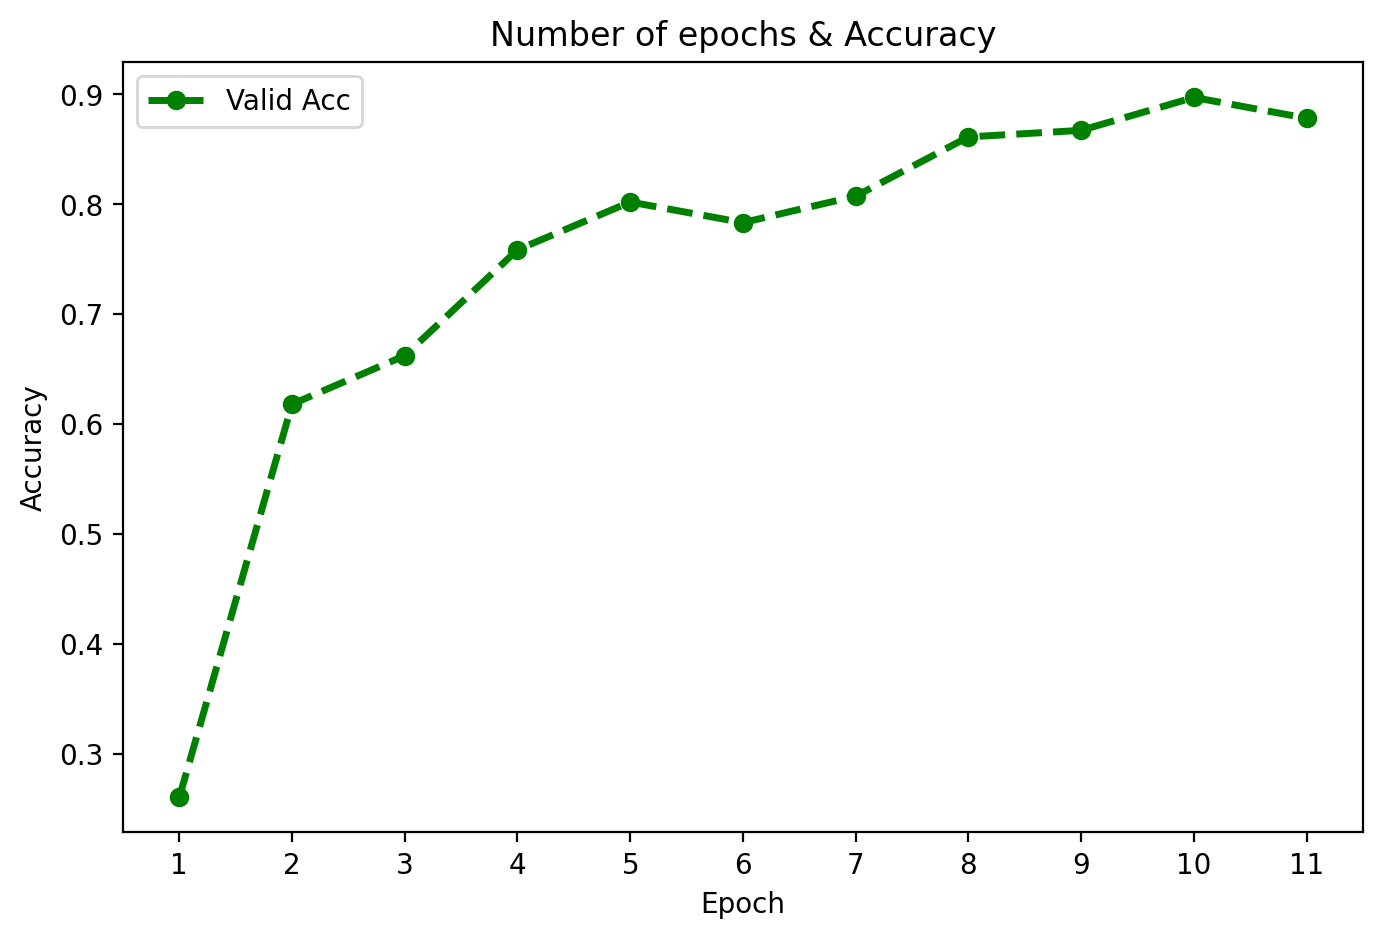

In [130]:
epoch_count = range(1,12)
plt.figure(figsize=(8,5), dpi=200)
plt.plot(epoch_count, val_acc, '--bo', color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Valid Acc'])
plt.title('Number of epochs & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,12,1))
plt.show();

In [138]:
# Load the saved weights
CNN_model.load_state_dict(torch.load('model_weight.pth'))
CNN_model = CNN_model.to(device)
#  Set the model to evaluation mode
CNN_model.eval()

#  Predict
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_dataloader:
        xb = xb.to(device)
        preds = torch.argmax(CNN_model(xb), dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

In [141]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        86
           1       1.00      0.95      0.98        63
           2       1.00      0.99      0.99        74
           3       1.00      1.00      1.00        74

    accuracy                           0.99       297
   macro avg       0.99      0.98      0.99       297
weighted avg       0.99      0.99      0.99       297



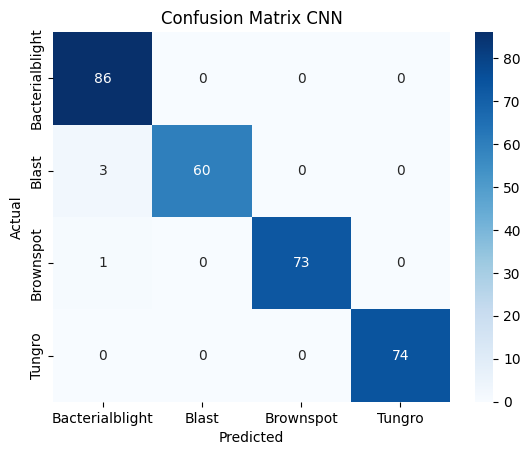

In [143]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_num,
            yticklabels=class_num)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix CNN")
plt.show()

# resnet50 with pretrained weights

In [61]:
#model_ft = models.resnet18(weights='IMAGENET_DEFAULT')
from torchvision.models import ResNet50_Weights

# Correct way to load pretrained weights
model_resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model_resnet = model_resnet.to(device)

summary(model_resnet, (3, 128,128))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [62]:
num_ftrs = model_resnet.fc.in_features

model_resnet.fc = nn.Linear(num_ftrs, 4)

In [64]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizers = optim.Adam(model_resnet.parameters(), lr=0.001, weight_decay=0.005)


# Training the resnet50 model

In [146]:
def train(model, train_loader, val_loader, epochs=5, device=device):
    train_loss ,train_acc,  val_loss, val_acc = [],[],[],[]
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizers.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            
        train_loss.append(total_loss)
        acc = correct / len(train_loader.dataset)
        train_acc.append(acc)
        print(f"Train Loss: {total_loss:.4f}, Accuracy: {acc:.2f}")

        # call Validation function........................
        lo,ac =validate(model, val_loader)
        val_acc.append(ac)
        val_loss.append(lo)
        
    torch.save(model.state_dict(), 'resnet50.pth')
    return train_loss ,train_acc,  val_loss, val_acc


def validate(model, val_loader):
    model.eval()
    correct = 0
    total_loss =0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            loss = criterion(outputs,labels)
            total_loss += loss.item()
    
    acc = correct / len(val_loader.dataset)
    print(f"Validation Accuracy: {acc:.4f}")
    
    return total_loss, acc

In [147]:
train_loss ,train_acc, val_loss,  val_acc = train(
    model=model_resnet, 
    train_loader=train_loader, 
    val_loader=valid_loader,
    epochs=10,
    device=device
)

Epoch 1/10: 100%|██████████| 65/65 [00:09<00:00,  7.20it/s]

Train Loss: 4.7671, Accuracy: 0.98


Validation Accuracy: 0.9521


Epoch 2/10: 100%|██████████| 65/65 [00:09<00:00,  7.18it/s]

Train Loss: 4.3810, Accuracy: 0.98


Validation Accuracy: 0.9454


Epoch 3/10: 100%|██████████| 65/65 [00:09<00:00,  7.21it/s]

Train Loss: 6.0395, Accuracy: 0.97


Validation Accuracy: 0.9622


Epoch 4/10: 100%|██████████| 65/65 [00:09<00:00,  7.21it/s]

Train Loss: 3.0311, Accuracy: 0.99


Validation Accuracy: 0.9730


Epoch 5/10: 100%|██████████| 65/65 [00:09<00:00,  7.11it/s]

Train Loss: 5.6489, Accuracy: 0.97


Validation Accuracy: 0.9494


Epoch 6/10: 100%|██████████| 65/65 [00:08<00:00,  7.23it/s]

Train Loss: 3.3330, Accuracy: 0.99


Validation Accuracy: 0.9946


Epoch 7/10: 100%|██████████| 65/65 [00:09<00:00,  7.20it/s]

Train Loss: 3.1424, Accuracy: 0.99


Validation Accuracy: 0.9751


Epoch 8/10: 100%|██████████| 65/65 [00:09<00:00,  7.22it/s]

Train Loss: 3.3509, Accuracy: 0.99


Validation Accuracy: 0.9407


Epoch 9/10: 100%|██████████| 65/65 [00:09<00:00,  7.21it/s]

Train Loss: 5.5069, Accuracy: 0.98


Validation Accuracy: 0.8038


Epoch 10/10: 100%|██████████| 65/65 [00:09<00:00,  7.20it/s]

Train Loss: 5.7127, Accuracy: 0.97


Validation Accuracy: 0.9885


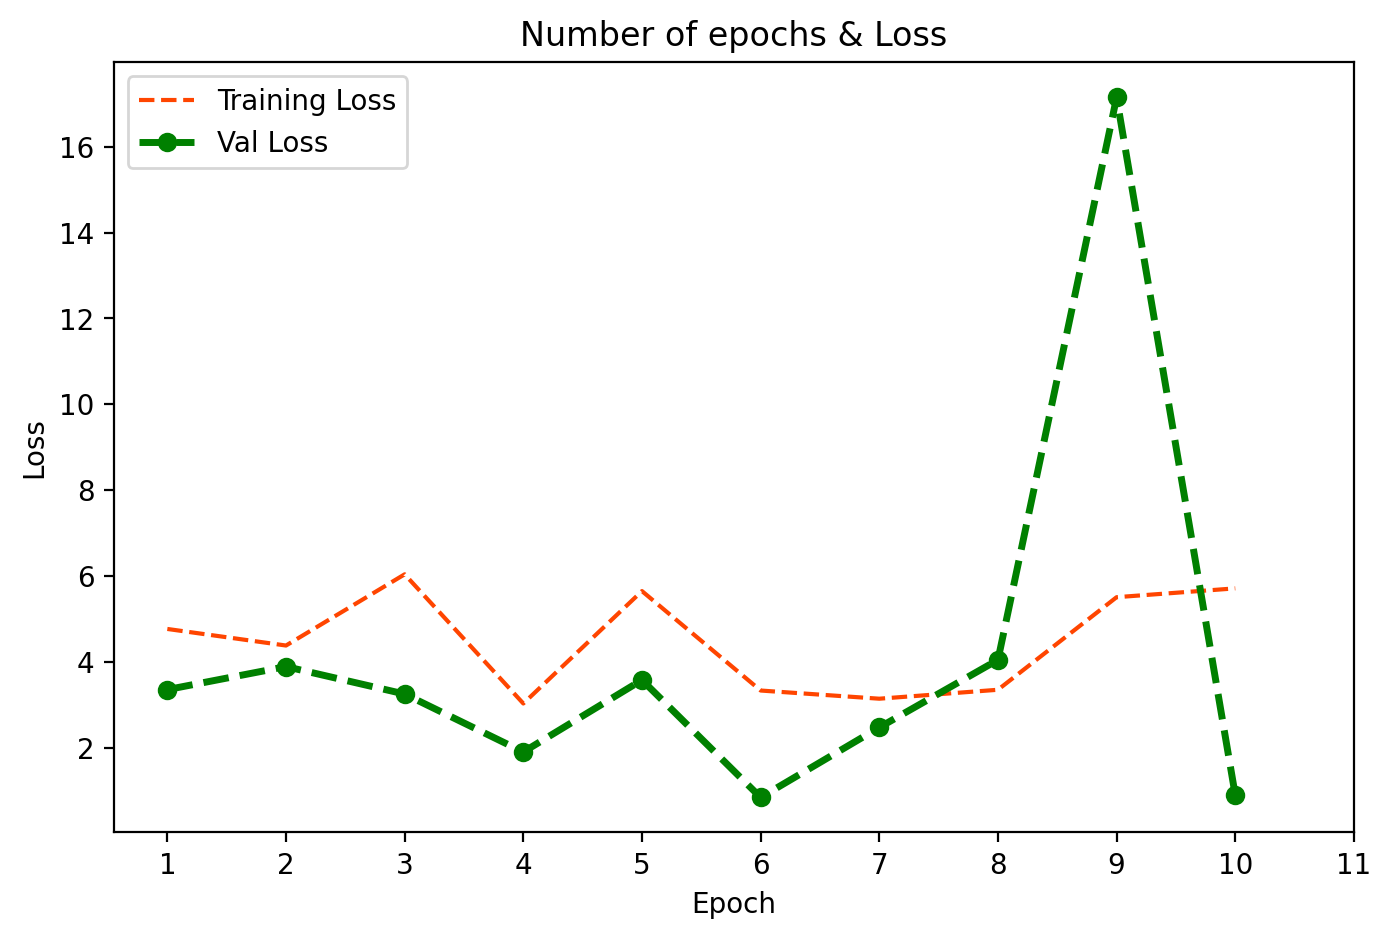

In [148]:
epoch_count = range(1,11)
plt.figure(figsize=(8,5), dpi=200)
plt.plot(epoch_count, train_loss, 'r--', color= 'orangered')
plt.plot(epoch_count, val_loss, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,12,1))
plt.show();

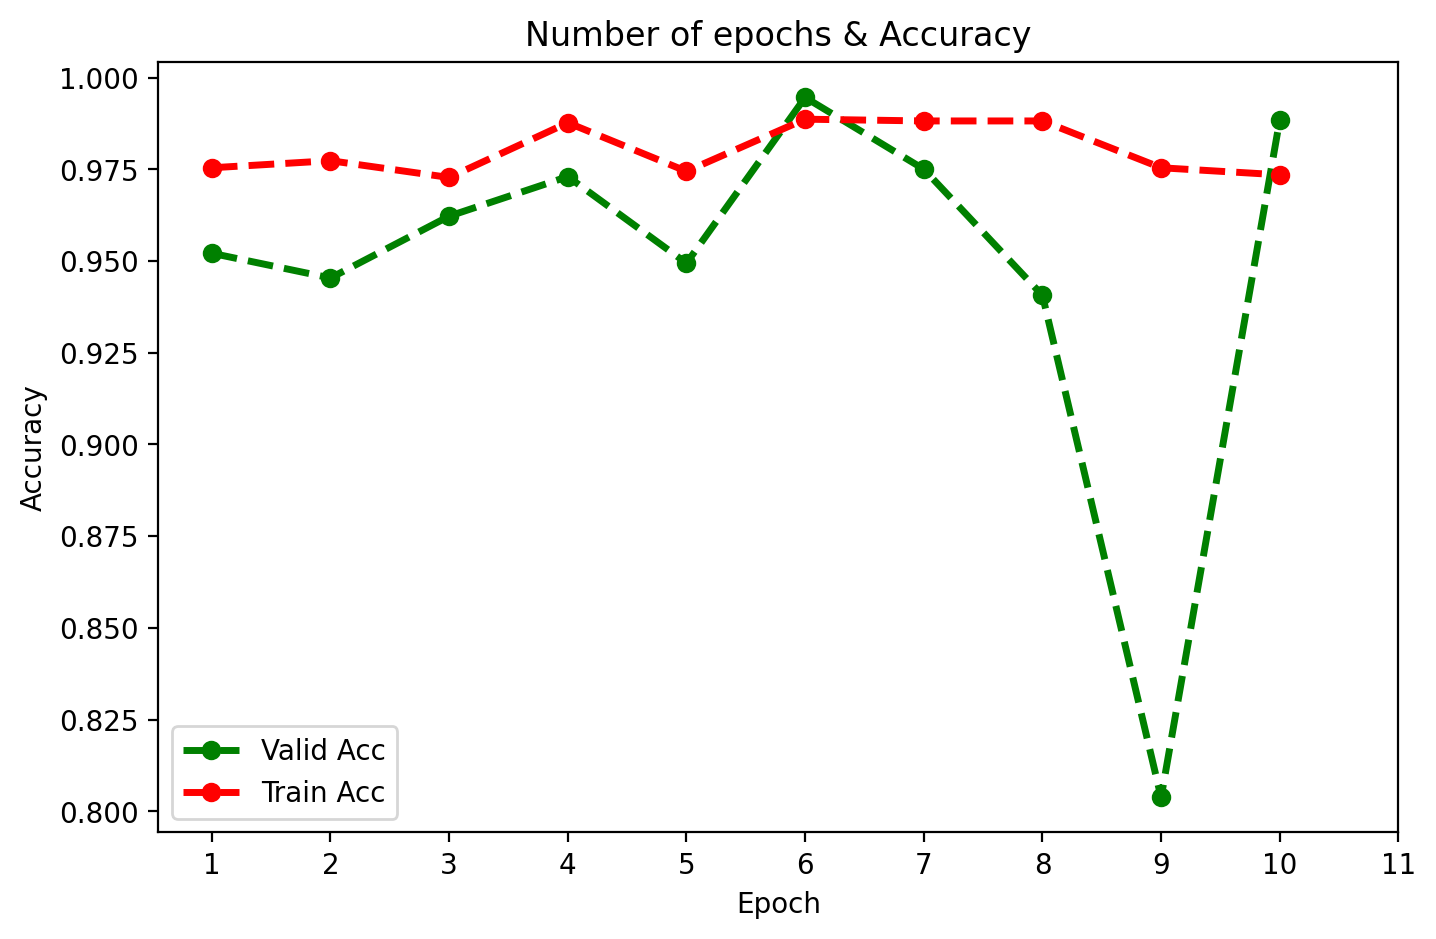

In [149]:
epoch_count = range(1,11)
plt.figure(figsize=(8,5), dpi=200)
plt.plot(epoch_count, val_acc, '--bo', color= 'green', linewidth = '2.5', label='line with marker')
plt.plot(epoch_count, train_acc, '--bo', color= 'red', linewidth = '2.5', label='line with marker')
plt.legend(['Valid Acc', 'Train Acc'])
plt.title('Number of epochs & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,12,1))
plt.show();

In [152]:
# Load the saved weights
model_resnet.load_state_dict(torch.load('resnet50.pth'))
model_resnet = model_resnet.to(device)
#  Set the model to evaluation mode
model_resnet.eval()

#  Predict
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_dataloader:
        xb = xb.to(device)
        preds = torch.argmax(model_resnet(xb), dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

In [153]:
print(classification_report(all_preds, all_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        85
           1       1.00      0.94      0.97        67
           2       0.97      1.00      0.99        72
           3       0.99      1.00      0.99        73

    accuracy                           0.99       297
   macro avg       0.99      0.99      0.99       297
weighted avg       0.99      0.99      0.99       297



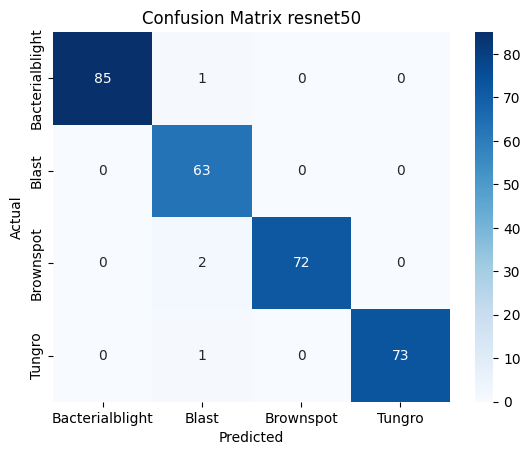

In [154]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_num,
            yticklabels=class_num)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix resnet50")
plt.show()